In [29]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression

import joblib

In [30]:
#load the data
file_name = 'trainDataset2025.xls'
df = pd.read_excel(file_name)

# EDA 

In [31]:
#first 5 rows of the dataset
print(df.head())

          ID  pCR (outcome)  RelapseFreeSurvival (outcome)   Age  ER  PgR  \
0  TRG002174              1                          144.0  41.0   0    0   
1  TRG002178              0                          142.0  39.0   1    1   
2  TRG002204              1                          135.0  31.0   0    0   
3  TRG002206              0                           12.0  35.0   0    0   
4  TRG002210              0                          109.0  61.0   1    0   

   HER2  TrippleNegative  ChemoGrade  Proliferation  ...  \
0     0                1           3              3  ...   
1     0                0           3              3  ...   
2     0                1           2              1  ...   
3     0                1           3              3  ...   
4     0                0           2              1  ...   

   original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                       0.517172   
1                                       0.444391   
2                   

In [32]:
print(df.describe())

       pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade  Proliferation  \
count  400.000000  400.000000       400.000000  400.000000     400.000000   
mean     2.902500    2.797500         2.830000    9.875000       6.562500   
std     49.932114   49.937068        49.935558   86.09291

In [33]:
df = df.rename(columns={'ID': 'PatientID', 'pCR (outcome)': 'PCR', 'RelapseFreeSurvival (outcome)': 'RFS'})

In [34]:
# replace "999" with NaN (Not a Number)
df = df.replace(999, np.nan)
print(df['RFS'].isna().sum())

0


In [35]:
print(df.head())

   PatientID  PCR    RFS   Age  ER  PgR  HER2  TrippleNegative  ChemoGrade  \
0  TRG002174  1.0  144.0  41.0   0  0.0   0.0              1.0         3.0   
1  TRG002178  0.0  142.0  39.0   1  1.0   0.0              0.0         3.0   
2  TRG002204  1.0  135.0  31.0   0  0.0   0.0              1.0         2.0   
3  TRG002206  0.0   12.0  35.0   0  0.0   0.0              1.0         3.0   
4  TRG002210  0.0  109.0  61.0   1  0.0   0.0              0.0         2.0   

   Proliferation  ...  original_glszm_SmallAreaHighGrayLevelEmphasis  \
0            3.0  ...                                       0.517172   
1            3.0  ...                                       0.444391   
2            1.0  ...                                       0.534549   
3            3.0  ...                                       0.506185   
4            1.0  ...                                       0.462282   

   original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
0                  

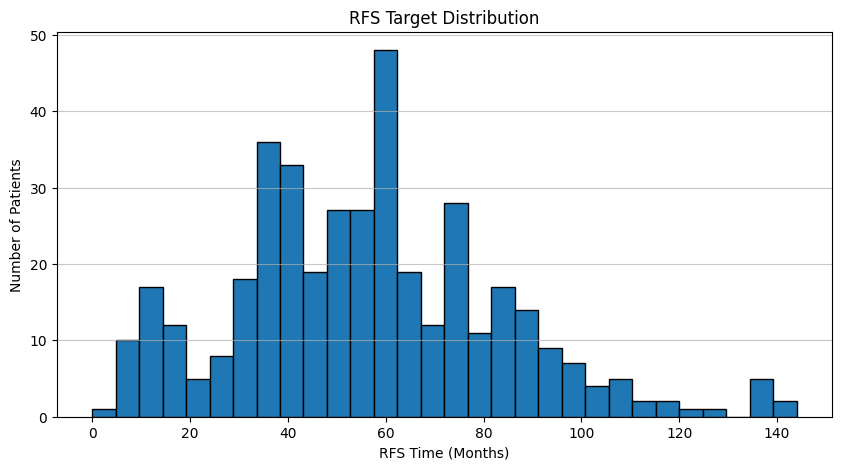

In [36]:
# Target (RFS)
plt.figure(figsize=(10, 5))
df['RFS'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('RFS Target Distribution')
plt.xlabel("RFS Time (Months)")
plt.ylabel("Number of Patients")
plt.grid(axis='y', alpha=0.7)
plt.show()


In [37]:
#features with missing values (NaN)
print(df.drop(columns=['PatientID', 'PCR', 'RFS']).isna().sum().sort_values(ascending=False).head(15))

Gene                              88
ChemoGrade                         3
HistologyType                      3
Proliferation                      2
HER2                               1
PgR                                1
TrippleNegative                    1
LNStatus                           1
Age                                0
ER                                 0
TumourStage                        0
original_shape_Elongation          0
original_shape_Flatness            0
original_shape_LeastAxisLength     0
original_shape_MajorAxisLength     0
dtype: int64


In [38]:
#defining feature and targets
y = df['RFS']
X = df.drop(columns=['PatientID', 'PCR', 'RFS'])

# mask = y.notna()
# X = X[mask]
# y = y[mask]

print(X.shape)
print(y.shape)
print(y.isna().sum())

(400, 118)
(400,)
0


# Preprocessing piplelines

In [39]:
# important features to be retained as per the assignment:ER, HER2 and Gene (Given in assignment: Implementation Requirement)

imp_features = ['ER', 'HER2', 'Gene']
other_features = [col for col in X.columns if col not in imp_features]

print("Total features: " + str(len(X.columns)))
print("Important features: " + str(len(imp_features)))
print("Remaining features: " + str(len(other_features)))

Total features: 118
Important features: 3
Remaining features: 115


In [40]:
# split train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


(320, 118) (80, 118)


In [41]:
# # Mandatory features
# X_train_imp = X_train[imp_features]
# X_test_imp  = X_test[imp_features]

# # Other features (all remaining features)
# X_train_other = X_train[other_features]
# X_test_other  = X_test[other_features]


In [42]:
# print(df.dtypes())

In [43]:
# # preprocessing other features 
# #impute(handling the missing values) and scaling

# from sklearn.pipeline import Pipeline
# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import StandardScaler

# other_prepro = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', StandardScaler())
# ])

# other_prepro.fit(X_train_other)
# X_train_other_final = other_prepro.transform(X_train_other)
# X_test_other_final  = other_prepro.transform(X_test_other)

# print(X_train_other_final.shape)

In [44]:
# # preprocess the importnt features
# #impute and scaling
# imp_prepro = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', StandardScaler())
# ])

# imp_prepro.fit(X_train_imp)
# X_train_imp_final = imp_prepro.transform(X_train_imp)
# X_test_imp_final  = imp_prepro.transform(X_test_imp)

# print(X_train_imp_final.shape)

In [45]:

# X_train_ready = np.hstack([X_train_imp_final, X_train_other_final])
# X_test_ready  = np.hstack([X_test_imp_final,  X_test_other_final])

# print(X_train_ready.shape)
# print(X_test_ready.shape)

In [46]:
from sklearn.compose import ColumnTransformer

# Preprocessing for important features
imp_transform = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Preprocessing for other features
other_transform = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_regression))
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ('imp', imp_transform, imp_features),
    ('other', other_transform, other_features)
])


# Building pipeline and Grid Search

In [47]:
# Model and hyperparameters
from sklearn.model_selection import GridSearchCV

models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

param_grids = {
    "RandomForest": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [5, 10, None],
        'preprocessor__other__selector__k': [50, 80, 115]
    },
    "GradientBoosting": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'preprocessor__other__selector__k': [50, 80, 115]
    },
    "SVR": {
        'model__C': [1, 10],
        'model__gamma': ['scale', 0.1, 1],
        'preprocessor__other__selector__k': [50, 80, 115]
    }
}

# Model Training, Selection, and Final Test Evaluation

In [48]:
# best_models = {}
# model_scores = {}

# for model_name, model in models.items():
#     # k = 5-fold CV 
#     gs = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    
#     gs.fit(X_train_ready, y_train)
    
#     best_models[model_name] = gs.best_estimator_
    
#     model_scores[model_name] = gs.best_score_
    
#     print(model_name + " best parameters: " + str(gs.best_params_))
#     print(model_name + " best CV MAE: " + str(round(-gs.best_score_, 2)))

# # the best model
# best_model_name = max(model_scores, key=model_scores.get)
# print("Overall Best Model: " + best_model_name)

# final_model = best_models[best_model_name]

# # testing the final model on test set
# final_pred = final_model.predict(X_test_ready)
# final_mae = mean_absolute_error(y_test, final_pred)

# print("Final Test MAE for " + best_model_name + ": " + str(round(final_mae, 2)))


In [49]:
best_models = {}
model_scores = {}

for model_name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Grid search
    gs = GridSearchCV(pipe, param_grid=param_grids[model_name], 
                      scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    
    gs.fit(X_train, y_train)
    
    best_models[model_name] = gs.best_estimator_
    model_scores[model_name] = -gs.best_score_
    
    print(model_name + " best parameters: " + str(gs.best_params_))
    print(model_name + " best CV MAE: " + str(round(-gs.best_score_, 2)))


RandomForest best parameters: {'model__max_depth': 10, 'model__n_estimators': 200, 'preprocessor__other__selector__k': 115}
RandomForest best CV MAE: 20.66
GradientBoosting best parameters: {'model__learning_rate': 0.01, 'model__n_estimators': 100, 'preprocessor__other__selector__k': 115}
GradientBoosting best CV MAE: 20.93
SVR best parameters: {'model__C': 10, 'model__gamma': 'scale', 'preprocessor__other__selector__k': 115}
SVR best CV MAE: 20.92


In [50]:
#Best model 
best_model_name = min(model_scores, key=model_scores.get)
print(f"Overall Best Model: {best_model_name}")

final_model = best_models[best_model_name]

# testing the model on test set
final_pred = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_pred)
print("Final Test MAE for " + best_model_name + ": " + str(round(final_mae, 2)))

Overall Best Model: RandomForest
Final Test MAE for RandomForest: 22.55


In [51]:
# saving the final best model
joblib.dump(final_model, 'rfs_model.joblib')

['rfs_model.joblib']